In [ ]:
#install required dependencies
!pip install selenium
!apt-get update 
!apt install chromium-chromedriver

#import selenium related packages
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from selenium.common import exceptions
from selenium.common.exceptions import NoSuchElementException

import time
import pandas as pd
import regex as re


In [ ]:
#function to load web driver for chrome
def load_driver(url):
  chrome_options = webdriver.ChromeOptions()
  chrome_options.add_argument('--headless')
  chrome_options.add_argument('--no-sandbox')
  chrome_options.add_argument('--disable-dev-shm-usage')
  driver = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
  driver.get(url)
  return (driver)

In [ ]:
url = 'https://locations.brand.com/' #url of the webpage of the brand with location details 
driver = load_driver(url)
driver1 = load_driver(url)
driver2 = load_driver(url)
driver3 = load_driver(url)
driver4 = load_driver(url)

df = pd.DataFrame(columns = ['Address'])

#class_div = 'Directory-content'
#class_div = 'Directory-listLink Link--directory'
class_div_statecount= 'Directory-listItem'         # no of states brand available  
class_div_stateurl= ".Directory-listItem [href]"   # url for specific state 

elems = driver.find_elements_by_class_name(class_div_statecount)
stateno = len(elems)
print("number of states brand present =",stateno)

elems = driver.find_elements_by_css_selector(class_div_stateurl)
print("url for the ", stateno, "state is", elems[stateno-1].get_attribute('href'))

webdriverwaittime = 2 #gen 5
delay = 2             #gen 10

#function chaining start here
all_state_page_parse(driver,webdriverwaittime)

final_df = pd.DataFrame(columns = ['Street Address', 'Street Number','City','State', 'ZipCode'])

#create a df in required format
create_finaldf(final_df,df)

#save to excel file
from google.colab import drive
drive.mount('/content/gdrive')
source = "/content/gdrive/MyDrive/Colab Notebooks/BrandList.xlsx"
from datetime import datetime
writer = pd.ExcelWriter(source) #.format(datetime.today().strftime('%y%m%d-%H%M%S'))) 
final_df.to_excel(writer,'sitelist')
#df.to_excel(writer,'Pass1')
writer.save()

Expect the brands location page to look somehting like below

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


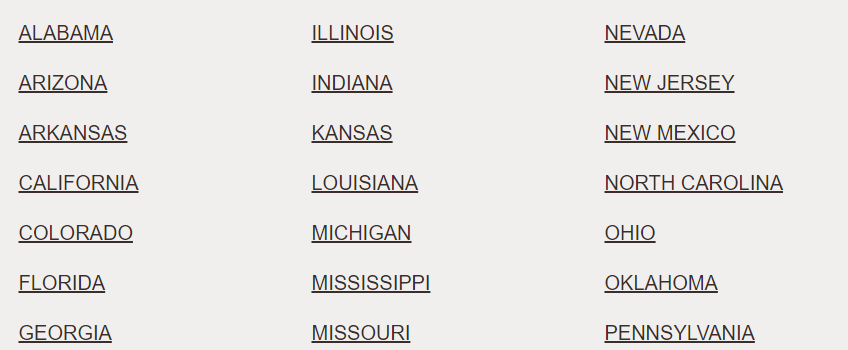

In [11]:
from IPython.display import Image
from google.colab import drive
drive.mount('/content/gdrive')
source = "/content/gdrive/MyDrive/Colab Notebooks/locations-snap.png"
Image(source)

In [ ]:
#function finds if the webpage has a nearby locations section        
def check_element_exists_by_class(driver):
    try:
        driver.find_element_by_class_name("c-nearby-locations-cta-wrapper")
        return True
    except NoSuchElementException:
        return False

In [ ]:
#function finds store address by parsing city level urls
def parse_city_links(url,webdriverwaittime=2):
    driver2.get(url)
    driver3.get(url)
    driver4.get(url)
    #class_div = 'Directory-content'
    #class_div = 'Directory-listItem'
    #class_div = 'DirectoryTeaser-address'
    #class_div = 'c-address-city'
    class_div2 = 'c-AddressRow'    #find address layers - gen 3 address rows - streetaddress \n city,state zip \n country but can be 4 e.g. streetaddress \n suiteno \n city,state zip \n country
    class_div3 = 'c-address'       #finds total number of locations on the page
    class_div4 = "c-nearby-locations-item" #finds total number of NEARBY locations on the page
    elems2 = WebDriverWait(driver2,webdriverwaittime).until(EC.presence_of_all_elements_located((By.CLASS_NAME,class_div2)))
    elems2 = driver2.find_elements_by_class_name(class_div2)
    count2 = 0
    count2 = len(elems2) 
    elems3 = WebDriverWait(driver3,webdriverwaittime).until(EC.presence_of_all_elements_located((By.CLASS_NAME,class_div3)))
    elems3 = driver3.find_elements_by_class_name(class_div3)
    count3=0
    count3 = len(elems3)
  
    flag = check_element_exists_by_class(driver2) #flag identifies if there is a nearby address section on the page
    print("flag value=", flag, "means there are nearby locations section present on webpage")
    if(flag==True):
      elems4 = WebDriverWait(driver4,webdriverwaittime).until(EC.presence_of_all_elements_located((By.CLASS_NAME,class_div4)))
      elems4 = driver4.find_elements_by_class_name(class_div4)
      count4=0
      count4 = len(elems4)
      print("there are ", count4," nearby locations present on the page") # these nearby locations are being double counted in the count2 so we will adjust count2
      count2 = (count3-count4)*3 # don't know how many address layers there are 3 or 4, estimating it to be 3 per address 

    print("c-address i.e. no of locations =", count3, "c-AddressRow i.e. total address layers =",count2)
    #elems[elem].text does not work always as some info is hidden so will use innerText 
    #print("1st element =", elems2[0].get_attribute('innerText'))
    elem =0
    while elem < count2:
        address = ''
        next_addr="\n"
        elem_cntr =0
        while next_addr!="":
          next_addr = elems2[elem+elem_cntr].get_attribute('innerText')
          print("elem =", elem, "elem_cntr=", elem_cntr, "next_addr =",next_addr)
          address = address + " " + next_addr +"\n"
          elem_cntr = elem_cntr + 1
          if(elem_cntr>=count2):
            break
        elem = elem + elem_cntr
        #print("address =", address)
        global df #global makes df confined not only to this function scope but uses global scope
        df = df.append({'Address': address}, ignore_index=True)
    print(df)
    return 

In [ ]:
#to test parse_city_links() - replace brand, store with correct details
#parse_store_links('https://locations.brand.com/az/phoenix')
#parse_store_links('https://local.brand.com/al/tuscaloosa/store.html')
#parse_store_links('https://local.brand.com/ak/anchorage.html')

In [ ]:
#function parse a specific state page and iterates through city specific urls
def parse_state_links(url,webdriverwaittime=2):
    driver1.get(url)
    try:
        elems = WebDriverWait(driver1,webdriverwaittime).until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, ".Directory-listItem [href]")))
        elems = driver1.find_elements_by_css_selector(".Directory-listItem [href]")
        for elem in elems:
            link = elem.get_attribute('href') 
            #print(link)
            time.sleep(delay)
            parse_city_links(link)
    except TimeoutException:
        pass
    return

In [ ]:
#function parses the index/main page and iterates through state specific urls
def all_state_page_parse(driver,webdriverwaittime):
  elems = WebDriverWait(driver,webdriverwaittime).until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, ".Directory-listItem [href]")))
  elems = driver.find_elements_by_css_selector(".Directory-listItem [href]")
  for elem in elems:
    links = elem.get_attribute('href')
    #print(links)
    time.sleep(delay)
    print (df)
    parse_state_links(links)

In [ ]:
#function formats the dataframe to store in an excel  
def reformat_address_for_excel(address,final_df):
  print("before split address=",address)
  split_addr = address.split("\n")
  print("new split address array =",split_addr)
  if(0):
    pass
    #remove empty strings ' ' & '' from a list
    #str_list = ["one", " " , "Two ", "three", "four", "five", " ", "six"," ", " ", "seven", "eight", " ", " " ,"Nine", "ten",  "   " ]
    #str_list = list(filter(lambda string : string.strip(), str_list))
    #print(str_list)
    #remove empty strings with ' ' only use #split_addr = [i for i in split_addr if i] 
  split_addr = list(filter(lambda string : string.strip(), split_addr))
  print("cleanuped address array=",split_addr) #['street_addr', 'street', 'city zipcode']
  len_addr = len(split_addr)
  print(len_addr)
  street = ' '
  city =' '
  state =' '
  if(len_addr>=3): # case of 4 address layers with a street numbers e.g. #['12542 W.Thomas Road', 'Ste. 101', ' Phinland, AZ 12345']
    street = split_addr[1] 
  else:
    pass             #street number will be blank in this case- we have 3 address layers
  #split last index on comma assuming gen structure ['Phinland, AZ 12345'] but could be PR structure [' Mayanagar 00903']
  city = split_addr[len_addr-1].split(',') 
  print(city)
  #check if split on ',' is a success
  if(len(city)==1):
    #split not success - could be PR case - [' Mayanagar 00903'] 
    city = split_addr[len_addr-1].split(' ') 
    city = list(filter(lambda string : string.strip(), city))
    print("split not success case, city =",city)
    state = city[0]
    zipcode = city[1]
    city = city[0] 
    state = "PR" # PR case  
    street_addr = split_addr[0]
  else:
    #split success
    state = city[1].split(' ') 
    zipcode = state[2]
    city = city[0]
    state = state[1]
    street_addr = split_addr[0]
  print('Street Address =',street_addr,'Street Number=',street,'City=',city ,'State=',state, 'ZipCode=',zipcode)
  final_df = final_df.append({'Street Address':street_addr,'Street Number':street,'City':city,'State':state, 'ZipCode':zipcode},ignore_index=True)
  return final_df

In [ ]:
#function creates final data frame in required format to save in excel 
def create_finaldf(final_df,df):
  #to test reformat function
  #reformat_address_for_excel("12542 Ave Host \nSte 255 \nMayanagar 00903",final_df)
  #reformat_address_for_excel("12542 W.Thomas Road \nSte. 101\nPhinland, AZ 12345",final_df)
  #reformat_address_for_excel(df["Address"][3],final_df)
  for i in range (0,len(df)):
    print (i)
    address = df["Address"][i]
    final_df = reformat_address_for_excel(address,final_df)
  final_df